In [8]:
import numpy as np
import networkx as nx
import os
import osmnx as ox
import time
import matplotlib.pyplot as plt

# Call this function to get the data 
def get_data(city='Detroit', mode='bike', root_path='../data/'):
    folders = os.listdir(root_path)
    for folder in folders:
        if folder == city:
            files = os.listdir(root_path+folder)
            bike_data = [file for file in files if mode in file][0]
            path = root_path + folder+ '/'+ bike_data;
    G = ox.load_graphml('C:/Users/nlepore/ComplexityScienceProject1/data/{}/{}_bike.graphml'.format(city,city))
    #G = ox.load_graphml('C:/Users/jzerez/Documents/Github/ComplexityScienceProject1/data/{}/{}_bike.graphml'.format(city,city))
    convert_lengths_to_floats(G)
    return G
    #return nx.read_graphml(path)

G = get_data()
print(type(G))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


#### Define helper functions to compute metrics

In [11]:
def convert_lengths_to_floats(G):
    """
    Changes the attributes of the edges of graph G such that the 'length' field
    is a float rather than a string
    """
    for u, v, d in list(G.edges(data=True)):
        d['length'] = float(d['length'])

def get_edge_length(G, u, v):
    """
    given two nodes in graph G, return the straight line distance 
    (as the crow flies) between them
    """
    xdist = float(G.nodes[u]['x']) - float(G.nodes[v]['x'])
    ydist = float(G.nodes[u]['y']) - float(G.nodes[v]['y'])
    length = (xdist**2 + ydist**2)**0.5
    return length

def make_new_random_edge(G, u=None):
    """
    Return a tuple of nodes representing a random new and unique edge
    """
    if not u:
        u = np.random.choice(G.nodes(), 1)
        u = u[0]
    
    available = [node for node in G.nodes() if node not in G[u]]
    
    # choose v if not specified
    v = np.random.choice(available, 1)
    v = v[0]
    return (u, v)

    
def calc_directness(G, u, v):
    """
        Calculate the directness between two nodes u and v
        Directness is the ratio between:
            - the shortest node path length (number of edges times the length of each edge)
            - the straight line distance between those two nodes
        If v cannot be reached from u, then directness is zero
        
        G: An nx graph
        u: the starting node
        v: the ending node
        
    """
    try:
        path_length = nx.shortest_path_length(G, source=u, target=v, weight='length')
        direct_length = get_edge_length(G, u, v)
        ret = direct_length/path_length
    except:
        return 0
    return ret

def calc_avg_directness_connected(G, n):
    """
    Calculates the average directness of n pairs of nodes. All of these nodes are already connected.
    G: An nx graph
    n: The number of pairs to use
    """
    d = 0
    for _ in range(n):
        start = np.random.choice(G.nodes(), 1)
        start = start[0]
        reachable = nx.descendants(G, start)
        if not reachable:
            continue
        end = np.random.choice(list(reachable), 1)
        end = end[0]

        d += (calc_directness(G, start, end) / n);
    return d

def calc_avg_directness_random(G, n):
    """
    Calculates the average directness of n pairs of nodes. These nodes are chosen at random. 
    If they are not connected, the directness is zero
    
    G: An nx graph
    n: the number of pairs to use
    """
    d = 0
    for _ in range(n):
        pairs = np.random.choice(G.nodes(), 2)
        d += calc_directness(G, pairs[0], pairs[1]) / n
    return d

def get_components(G):
    '''
    Get the connected components of G
    G: An nx graph
    
    Outputs
    wcc: A list of the components sorted by size
    '''
    wcc = [cc for cc in nx.weakly_connected_component_subgraphs(G)]
    wcc.sort(key=len, reverse=True)
    return wcc

def calc_lcc(G):
    '''
    Returns the number of nodes in the largest component of graph G
    G: An nx graph
    '''
    wcc = get_components(G)
    return len(wcc[0])

def euclidean_dist_vec(y1, x1, y2, x2):
    '''
    Calculate the euclidean distance between two points.
    '''
    distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    return distance
def connected_pairs(G, n):
    '''
    Creates n pairs of connected nodes from graph G
    G: an nx graph
    n: the number of pairs to return
    '''
    for _ in range(n):
        start = np.random.choice(G.nodes(), 1)
        start = start[0]
        reachable = nx.descendants(G, start)
        if not reachable:
            continue
        end = np.random.choice(list(reachable), 1)
        end = end[0]
        
def random_pairs(G, n):
    '''
    Creates n pairs of random nodes from graph G
    G: an nx graph
    n: the number of pairs to return
    '''
    
    
def connectedness(G):
    N = len(G)
    wcc = get_components(G)
    largest = wcc[0]
    N_ = len(largest)
    return N_/N
    

#### Define Methods for connecting the Graphs

In [9]:
def L2S(wcc):
    '''
    Find the closest pair of nodes between two different connected components.
    ---
    wcc: list connected components

    returns: dict nodes i and j and distance
    '''
    closest_pair = {'i': 0, 'j': 0, 'dist': np.inf}
#    print('largest to second:')
#    print(len(wcc[0]))
#    print(len(wcc[1]))
    for i in wcc[0].nodes(data=True):
        i_coord = (i[1]['y'], i[1]['x'])
        for j in wcc[1].nodes(data=True):
            j_coord = (j[1]['y'], j[1]['x'])
            dist = euclidean_dist_vec(i_coord[0], i_coord[1], j_coord[0], j_coord[1])
            if dist < closest_pair['dist']:
                closest_pair['i'] = i[0]
                closest_pair['j'] = j[0]
                closest_pair['dist'] = dist
    return closest_pair

def L2C(wcc):
    closest_pair = {'i': 0, 'j': 0, 'dist': np.inf}
    for i in wcc[0].nodes(data=True):
        i_coord = (i[1]['y'], i[1]['x'])
        for j in wcc[1:]:
            for k in j.nodes(data=True):
                j_coord = (k[1]['y'], k[1]['x'])
                dist = euclidean_dist_vec(float(i_coord[0]), float(i_coord[1]), float(j_coord[0]), float(j_coord[1]))
                if dist < closest_pair['dist']:
                    closest_pair['i'] = i[0]
                    closest_pair['j'] = k[0]
                    closest_pair['dist'] = dist
    return closest_pair

def R2C(wcc):
    '''
    Find the closest pair of nodes between two different connected components.
    ---
    wcc: list connected components

    returns: dict nodes i and j and distance
    '''
    closest_pair = {'i': 0, 'j': 0, 'dist': np.inf}
    num_clusters = len(wcc)
    cluster = np.random.choice(len(wcc))
    for i in wcc[cluster].nodes(data=True):
        i_coord = (i[1]['y'], i[1]['x'])
        for w,j in enumerate(wcc[1:]):
            if w == cluster - 1:
                break
            for k in j.nodes(data=True):
                j_coord = (k[1]['y'], k[1]['x'])
                dist = euclidean_dist_vec(float(i_coord[0]), float(i_coord[1]), float(j_coord[0]), float(j_coord[1]))
                if dist < closest_pair['dist']:
                    closest_pair['i'] = i[0]
                    closest_pair['j'] = k[0]
                    closest_pair['dist'] = dist
    return closest_pair

def Closest(wcc):
    closest_pair = {'i': 0, 'j': 0, 'dist': np.inf}
    for v,i in enumerate(wcc[0:]):
            for u in i.nodes(data=True):
                i_coord = (u[1]['y'], u[1]['x'])
                for w,j in enumerate(wcc[0:]):
                    if w == v:
                        break
                    for k in j.nodes(data=True):
                        j_coord = (k[1]['y'], k[1]['x'])
                        dist = euclidean_dist_vec(float(i_coord[0]), float(i_coord[1]), float(j_coord[0]), float(j_coord[1]))
                        if dist < closest_pair['dist']:
                            closest_pair['i'] = u[0]
                            closest_pair['j'] = k[0]
                            closest_pair['dist'] = dist
    return closest_pair


In [70]:
def new_city(G, algy, length):
    """
    wcc = Sorted list of weakly connected subgraphs
    algy = desired path-adding algorithm
    
    """
    added_edges = []
    tot_length = [0]
    directness_connected = []
    directness_random = []
    lccs = []
    connectedness_rank  =[]
    i = 0
    while sum(tot_length) < length:
        wcc = get_components(G)
        print(sum(tot_length))
        lccs.append(len(wcc[0]))
        directness_connected.append(calc_avg_directness_connected(G, 100))
        directness_random.append(calc_avg_directness_random(G, 100))
        connected_rank = connectedness_rank.append(connectedness(G))
        added_edge = algy(wcc)
        edge = (added_edge['i'],added_edge['j'],added_edge['dist'])
        G.add_edge(edge[0], edge[1], length = edge[2])
        added_edges.append(edge)
        tot_length.append(edge[2])
        
        
        i = i+1
    wcc = get_components(G)
    lccs.append(len(wcc[0]))
    directness_connected.append(calc_avg_directness_connected(G, 1000))
    directness_random.append(calc_avg_directness_random(G, 1000))
    connected_rank = connectedness_rank.append(connectedness(G))
    return G, added_edges, tot_length, directness_connected, directness_random, lccs, connectedness_rank

In [71]:
name = 'Detroit'
G = get_data(name)

len(G)

G_new, edges, lengths, direcness1, directness2, lccs, connectedness_rank = new_city(G, L2S, 35000)

0
largest to second:
732
527
3407.35413711116
largest to second:
1259
453
11204.485270146066
largest to second:
1712
315
11219.224571613475
largest to second:
2027
306
11537.580868474
largest to second:
2333
124
11554.563952354174
largest to second:
2457
87
13614.288861129877
largest to second:
2544
84
14244.579437543023
largest to second:
2628
81
14332.553865229462
largest to second:
2709
81
14868.53276227046
largest to second:
2790
62
14886.305132267327
largest to second:
2852
56
18669.500902128075
largest to second:
2908
53
20085.862683595467
largest to second:
2961
43
20102.67710114398
largest to second:
3004
40
20112.81850857975
largest to second:
3044
40
21042.217012444362
largest to second:
3084
39
26017.044933627498
largest to second:
3123
39
26057.973615438405
largest to second:
3162
37
26072.275452620044
largest to second:
3199
36
26318.488444777668
largest to second:
3235
34
27073.055890689717
largest to second:
3269
31
27081.90808213464
largest to second:
3300
28
27286.0805

In [73]:
name = 'Detroit'
G = get_data(name)

len(G)

G_new_L2C, edges_L2C, lengths_L2C, direcness1_L2C, directness2_L2C, lccs_L2C, connectedness_rank_L2C = new_city(G, L2C, 35000)

0
9.872905430500484
17.918093106861612
30.876620985513675
45.615922452922554
63.388292449789866
104.3169742606974
153.502662303705
164.78355224231018
213.97135885421568
267.676613507439
333.1896912992405
498.7216222110553
534.0361885720989
714.9914051197062
715.0493367441525
723.9015281890748
811.8759558755128
996.7006949950674
1196.802441089261
1400.9749099637454
1410.354716772789
1656.5677089304118
1888.2987683987851
2222.8688423611648
2230.8502248300492
2240.5485104763447
2558.904807336871
2569.0462147726375
2744.0519451519444
3188.027150667866
3652.07902682669
4151.394726246322
4687.37362328732
4738.302648038453
4749.810096330177
5380.620705421195
6191.775194965097
7121.17369882971
8954.496957236019
9048.670853828135
9912.606740578774
10486.864365897922
12546.589274673624
12563.572358553798
12577.87419573544
13512.296082968582
13524.571232459873
14789.699535290994
17335.764604449705
19024.241590457845
22077.74899854413
25626.929779426275


37


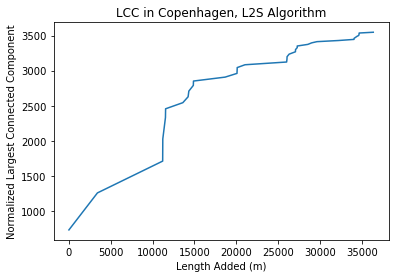

In [74]:
print(len(connectedness_rank))
plt.plot(np.cumsum(lengths), lccs)

plt.title('LCC in Copenhagen, L2S Algorithm')
plt.xlabel('Length Added (m)')
plt.ylabel('Normalized Largest Connected Component')
plt.show()

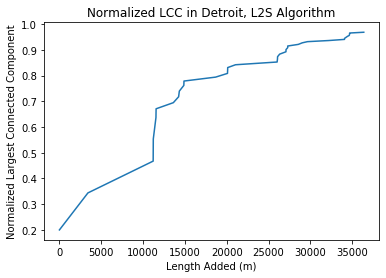

In [75]:
plt.plot(np.cumsum(lengths),connectedness_rank)

plt.title('Normalized LCC in Detroit, L2S Algorithm')
plt.xlabel('Length Added (m)')
plt.ylabel('Normalized Largest Connected Component')
plt.show()

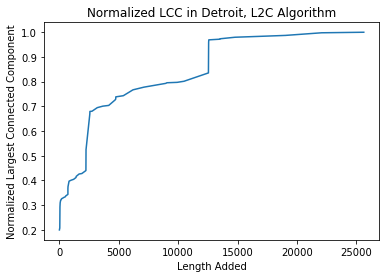

In [76]:
plt.plot(np.cumsum(lengths_L2C),connectedness_rank_L2C)

plt.title('Normalized LCC in Detroit, L2C Algorithm')
plt.xlabel('Length Added')
plt.ylabel('Normalized Largest Connected Component')
plt.show()

In [54]:
name = 'Copenhagen'
G = get_data(name)

len(G)

Copenhagen_new, CO_edges, CO_lengths, CO_direcness1, CO_directness2, CO_lccs, CO_connectedness_rank = new_city(G, L2S, 5000)



0
largest to second:
6662
2217
7.12094944317116
largest to second:
8879
539
691.771038328194
largest to second:
9418
386
1088.6168418953218
largest to second:
9804
351
1125.028994587038
largest to second:
10155
274
1136.5978714157109
largest to second:
10429
265
1195.157619417889
largest to second:
10694
222
1223.7990769803703
largest to second:
10916
104
1273.2096193196312
largest to second:
11020
98
1287.1823799569574
largest to second:
11118
92
1295.8682408348634
largest to second:
11210
90
1496.883128967069
largest to second:
11300
78
1581.2561589041372
largest to second:
11378
60
1600.1153886346751
largest to second:
11438
47
1626.0554712957596
largest to second:
11485
45
1873.284585246106
largest to second:
11530
42
1938.4664147124483
largest to second:
11572
38
1974.6158215713663
largest to second:
11610
33
2094.096217384714
largest to second:
11643
32
2225.4854484874168
largest to second:
11675
32
2409.895451815872
largest to second:
11707
32
2504.0622171377045
largest to secon

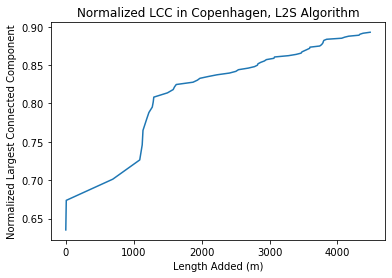

In [56]:
plt.plot(np.cumsum(AM_lengths[:len(AM_lengths)-1]),AM_connectedness_rank)

plt.title('Normalized LCC in Copenhagen, L2S Algorithm')
plt.xlabel('Length Added (m)')
plt.ylabel('Normalized Largest Connected Component')
plt.show()

In [59]:
name = 'Copenhagen'
G = get_data(name)

len(G)

Copenhagen_new_L2C, CO_edges_L2C, CO_lengths_L2C, CO_direcness1_L2C, CO_directness2_L2C, CO_lccs_L2C, CO_connectedness_rank_L2C = new_city(G, L2C, 5000)


0
2.754564895988672
6.258045030931947
10.562293524136303
14.944127035556672


KeyboardInterrupt: 

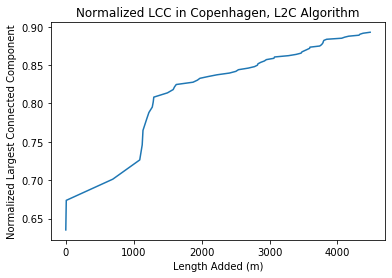

In [58]:
plt.plot(np.cumsum(CO_lengths_L2C[:len(CO_lengths_L2C)-1]),CO_connectedness_rank_L2C)

plt.title('Normalized LCC in Copenhagen, L2C Algorithm')
plt.xlabel('Length Added (m)')
plt.ylabel('Normalized Largest Connected Component')
plt.show()

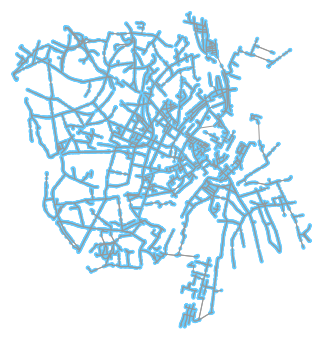

In [60]:
wcc = get_components(G_new)
G_super = nx.compose(wcc[0], wcc[1])
colors = ['r', 'b', 'g', 'y', 'm', 'k', 'c']

ox.plot_graph(G_super)
# plt.figure()


# for i in range(3):
#     f, ax = ox.plot_graph(wcc[i], edge_color=colors[i%7], node_color=colors[i%7], show=False, close=False)
    
plt.show()
# ox.plot_graph(G_new)

AttributeError: 'Figure' object has no attribute 'plt'

[6662, 8879, 8879, 8879]


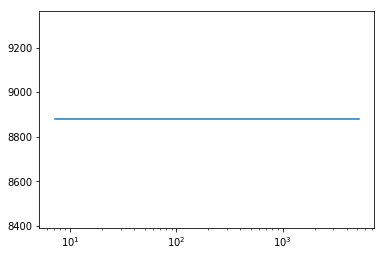

[6662, 8879, 8879, 8879]

In [44]:

import matplotlib.pyplot as plt

# plt.plot(lengths, direcness1)
# plt.plot(lengths, directness2)
# plt.plot(lengths, lccs)
# plt.show()

print(lccs)
plt.figure
plt.semilogx(lengths[7:], lccs[1:])
plt.show()
lengths[6:]
lccs

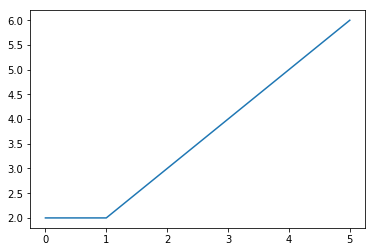

In [36]:
plt.figure()
plt.plot([0,1,2,3,4,5], [2,2,3,4,5,6])
plt.show()
# ox.plot_graph(G_new)

In [52]:
sum(lengths)
edges

[(824620150, 174101627, 1207.129340637136),
 (1342036774, 30153896, 2745.060281655068),
 (123892541, 808367492, 34.04993383654771),
 (46565157, 5324097817, 4274.262644050204),
 (46515337, 46313604, 6738.97290886752),
 (1509163403, 286565233, 11064.33901629516),
 (46235775, 46467690, 6887.574948240108),
 (46467276, 1332094219, 3034.4038941095473)]